<a href="https://www.kaggle.com/code/mohamedbakrey/detect-the-fake-and-true-news-by-using-bi-lstm?scriptVersionId=118025197" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <p style="background-color:#627D78;font-family:newtimeroman;color:#D5CABD;font-size:150%;text-align:center;border-radius:20px 60px;">Detect the Fake and True News by using Bi-LSTM </p>

### <p style="background-color:#627D78;font-family:newtimeroman;color:#D5CABD;font-size:150%;text-align:center;border-radius:20px 60px;">Loading Package</p>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import re, string, unicodedata
from string import punctuation
from termcolor import colored
from collections import Counter


from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet

import keras
import tensorflow as tf
from keras.preprocessing import text, sequence
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer

import nltk
from nltk.corpus import stopwords
from textblob import Word
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

from warnings import filterwarnings
filterwarnings('ignore')

from sklearn import set_config
set_config(print_changed_only = False)

print(colored("\nLIBRARIES WERE SUCCESFULLY IMPORTED...", "red"))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...



LIBRARIES WERE SUCCESFULLY IMPORTED...


<a id="3"></a>
# <p style="background-color:#627D78;font-family:newtimeroman;color:#D5CABD;font-size:150%;text-align:center;border-radius:20px 60px;">Loading Data</p>

In [2]:
df_true_news = pd.read_csv("../input/fake-and-real-news-dataset/True.csv")
df_fake_news = pd.read_csv("../input/fake-and-real-news-dataset/Fake.csv")
GLOVE_EMBEDDING = "../input/glove-twitter/glove.twitter.27B.100d.txt"

<a id="3"></a>
# <p style="background-color:#627D78;font-family:newtimeroman;color:#D5CABD;font-size:150%;text-align:center;border-radius:20px 60px;">Data Exploration</p>

In [3]:
# Read the true news
df_true_news.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
# Read the fake new
df_fake_news.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [5]:
print("The shape of true news: ", df_true_news.shape)
print("The shape of fake news: ", df_fake_news.shape)

The shape of true news:  (21417, 4)
The shape of fake news:  (23481, 4)


In [6]:
# Make concatinate for the data
df_true_news["news_class"], df_fake_news["news_class"] = 1, 0

news_after_make_concate = pd.concat([df_true_news, df_fake_news])

In [7]:
print("Shape of the data after make concate : ",news_after_make_concate.shape)

Shape of the data after make concate :  (44898, 5)


In [8]:
# Show the information for the data
news_after_make_concate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   title       44898 non-null  object
 1   text        44898 non-null  object
 2   subject     44898 non-null  object
 3   date        44898 non-null  object
 4   news_class  44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


In [9]:
#check the null value
news_after_make_concate.isna().sum()

title         0
text          0
subject       0
date          0
news_class    0
dtype: int64

In [10]:
# calculate the duplicate
print("The Number of duplicate :",news_after_make_concate.duplicated().sum() )

The Number of duplicate : 209


In [11]:
# Here we can delet the duplicate 
print("Remove The duplicate:",news_after_make_concate.drop_duplicates(inplace=True))

Remove The duplicate: None


In [12]:
# check the value count of the classes we have in the data
print("The count of news_class: \n" ,news_after_make_concate.news_class.value_counts())

The count of news_class: 
 0    23478
1    21211
Name: news_class, dtype: int64


In [13]:
# Check the value of subject 
print("The value count of subject : \n", news_after_make_concate.subject.value_counts())

The value count of subject : 
 politicsNews       11220
worldnews           9991
News                9050
politics            6838
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64


In [14]:
# Check the value count for the title
print("The value count of title : \n", news_after_make_concate.title.value_counts())

The value count of title : 
 Factbox: Trump fills top jobs for his administration                                                     14
Factbox: Contenders for senior jobs in Trump's administration                                             8
MEDIA IGNORES Time That Bill Clinton FIRED His FBI Director On Day Before Vince Foster Was Found Dead     6
Factbox: International reaction to arrest of Reuters reporters in Myanmar                                 6
Factbox: Contenders, picks for key jobs in Trump's administration                                         5
                                                                                                         ..
North Korea images suggest missile capable of hitting all America: U.S. experts                           1
China customs handles 2,773 cases of smuggling from January-October: paper                                1
Honduran vote count gives Hernandez 1 point lead over rival                                               1

<a id="3"></a>
# <p style="background-color:#627D78;font-family:newtimeroman;color:#D5CABD;font-size:150%;text-align:center;border-radius:20px 60px;">Data visualization</p>

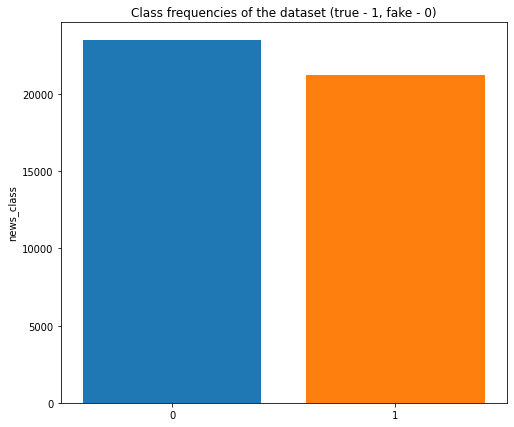

In [15]:
plt.figure(figsize = [8, 7], clear = True, facecolor = 'white')

sns.barplot(x = news_after_make_concate["news_class"].value_counts().index,
            y = news_after_make_concate["news_class"].value_counts(),
            saturation = 1).set(title = "Class frequencies of the dataset (true - 1, fake - 0)");

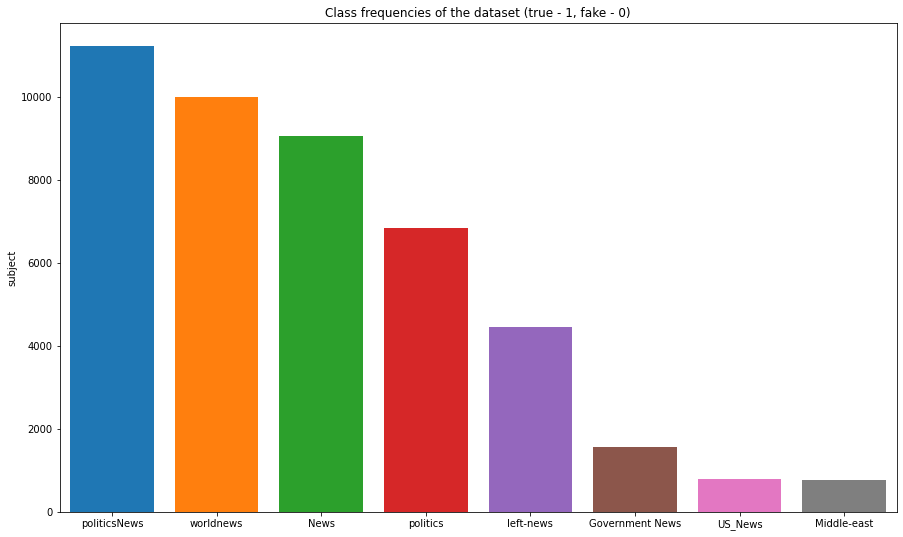

In [16]:
plt.figure(figsize = [15, 9], clear = False, facecolor = 'white',edgecolor='black')
sns.barplot(x = news_after_make_concate["subject"].value_counts().index,
            y = news_after_make_concate["subject"].value_counts(),
            saturation = 1).set(title = "Class frequencies of the dataset (true - 1, fake - 0)");

In [17]:
fig = px.pie(data_frame = news_after_make_concate, names = "news_class", hole = 0.4, title = "counts in news_class",
             width = 1000, height = 500, color_discrete_sequence = px.colors.sequential.Sunset_r)

fig.update_traces(textposition = "inside", textinfo = "percent+label",
                  marker = dict(line = dict(width = 1.2, color = "#000000")))

fig.update_layout(title_x = 0.5, title_font = dict(size = 30), uniformtext_minsize = 25)

fig.show()

In [18]:
fig = px.pie(news_after_make_concate, names = "subject", title = "counts in news_class", hole = 0.5,
            width = 1000, height = 500, color_discrete_sequence = px.colors.sequential.Sunset_r)

fig.update_traces(textposition = "inside", textinfo = "percent+label",
                  marker = dict(line = dict(width = 1.2, color = "#000000")))

fig.update_layout(title_x = 0.5, title_font = dict(size = 30), uniformtext_minsize = 25)

fig.show()

<function matplotlib.pyplot.show(close=None, block=None)>

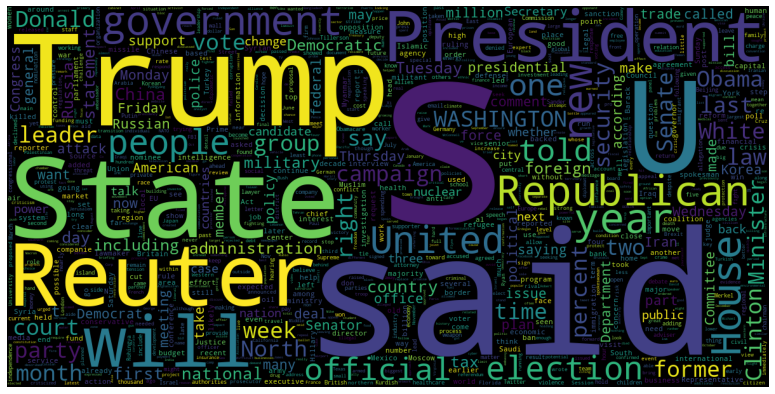

In [19]:
# Wordcloud for true news

text = " ".join(i for i in df_true_news.text)

wc = WordCloud(background_color = "black", width = 1200, height = 600,
               contour_width = 0, contour_color = "red", max_words = 1000,
               scale = 1, collocations = False, repeat = True, min_font_size = 1)

wc.generate(text)

plt.figure(figsize = [15, 7])
plt.imshow(wc)
plt.axis("off")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

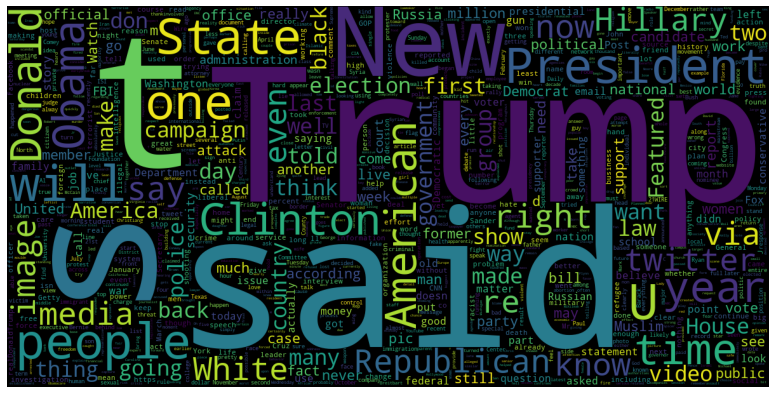

In [20]:
# Wordcloud for fake news
text = " ".join(i for i in df_fake_news.text)

wc = WordCloud(background_color = "black", width = 1200, height = 600,
               contour_width = 0, contour_color = "red", max_words = 1000,
               scale = 1, collocations = False, repeat = True, min_font_size = 1)

wc.generate(text)

plt.figure(figsize = [15, 7])
plt.imshow(wc)
plt.axis("off")
plt.show

### Cleaning Data

In [21]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [22]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
news_after_make_concate['text']=news_after_make_concate['text'].apply(denoise_text)

In [23]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(news_after_make_concate.text)
corpus[:5]

['WASHINGTON', '(Reuters)', 'head', 'conservative', 'Republican']

In [24]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'Trump': 100870,
 'said': 92268,
 'would': 53999,
 'U.S.': 45687,
 'people': 32819,
 'President': 32114,
 'also': 30114,
 'one': 29176,
 'Donald': 26941,
 'said.': 25929}

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# Calculate the Unigram Analysis

<AxesSubplot:>

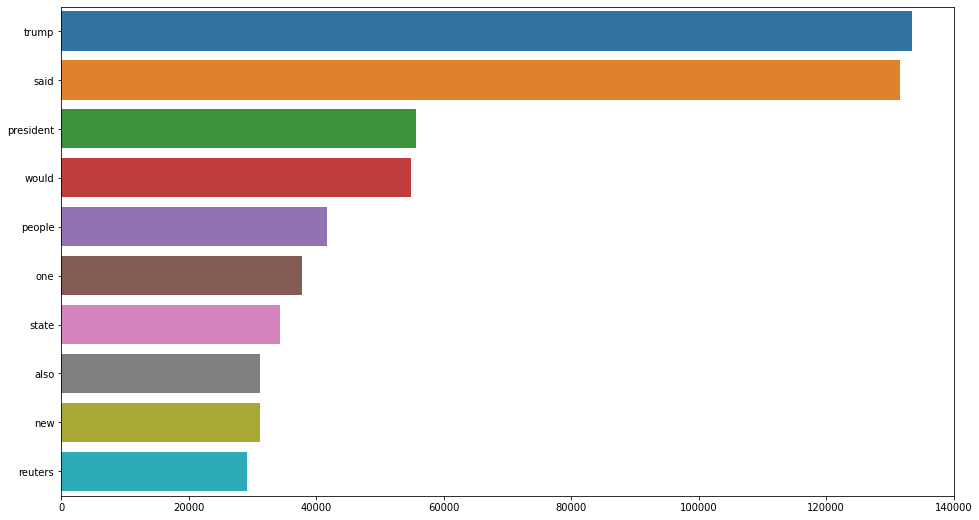

In [26]:
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams(news_after_make_concate.text,10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))


## Calculate the Bigram Analysis Analysis


<AxesSubplot:>

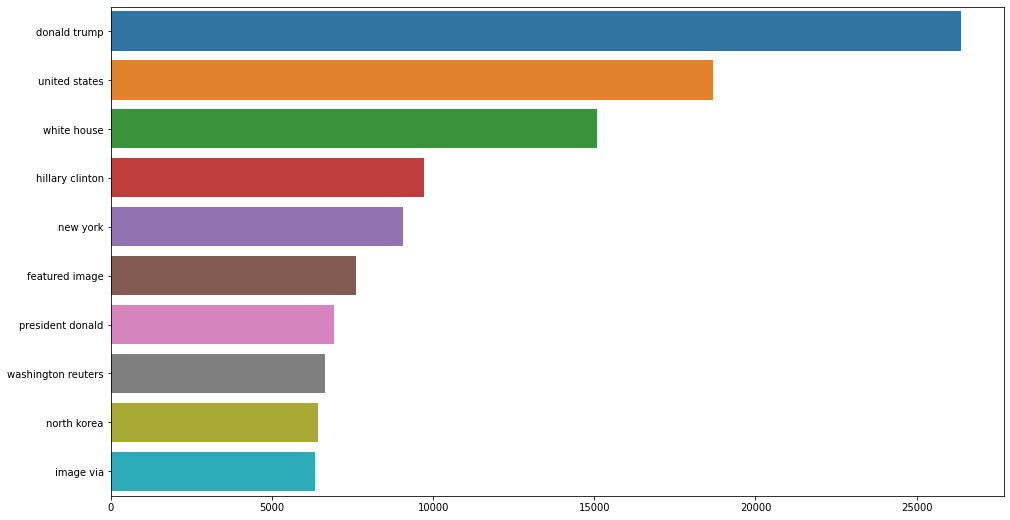

In [27]:
plt.figure(figsize = (16,9))
most_common_bi = get_top_text_ngrams(news_after_make_concate.text,10,2)
most_common_bi = dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))

In [28]:
#look at the latest condition of the dataset

news_after_make_concate.head(n = 10).style.background_gradient(cmap = "summer")

,title,text,subject,date,news_class
0,"As U.S. budget fight looms, Republicans flip their fiscal script","WASHINGTON (Reuters) head conservative Republican faction U.S. Congress, voted month huge expansion national debt pay tax cuts, called “fiscal conservative” Sunday urged budget restraint 2018. keeping sharp pivot way among Republicans, U.S. Representative Mark Meadows, speaking CBS’ “Face Nation,” drew hard line federal spending, lawmakers bracing battle January. return holidays Wednesday, lawmakers begin trying pass federal budget fight likely linked issues, immigration policy, even November congressional election campaigns approach Republicans seek keep control Congress. President Donald Trump Republicans want big budget increase military spending, Democrats also want proportional increases non-defense “discretionary” spending programs support education, scientific research, infrastructure, public health environmental protection. “The (Trump) administration already willing say: ‘We’re going increase non-defense discretionary spending ... 7 percent,’” Meadows, chairman small influential House Freedom Caucus, said program. “Now, Democrats saying that’s enough, need give government pay raise 10 11 percent. fiscal conservative, don’t see rationale is. ... Eventually run people’s money,” said. Meadows among Republicans voted late December party’s debt-financed tax overhaul, expected balloon federal budget deficit add $1.5 trillion 10 years $20 trillion national debt. “It’s interesting hear Mark talk fiscal responsibility,” Democratic U.S. Representative Joseph Crowley said CBS. Crowley said Republican tax bill would require United States borrow $1.5 trillion, paid future generations, finance tax cuts corporations rich. “This one least ... fiscally responsible bills we’ve ever seen passed history House Representatives. think we’re going paying many, many years come,” Crowley said. Republicans insist tax package, biggest U.S. tax overhaul 30 years, boost economy job growth. House Speaker Paul Ryan, also supported tax bill, recently went Meadows, making clear radio interview welfare “entitlement reform,” party often calls it, would top Republican priority 2018. Republican parlance, “entitlement” programs mean food stamps, housing assistance, Medicare Medicaid health insurance elderly, poor disabled, well programs created Washington assist needy. Democrats seized Ryan’s early December remarks, saying showed Republicans would try pay tax overhaul seeking spending cuts social programs. goals House Republicans may take back seat Senate, votes Democrats needed approve budget prevent government shutdown. Democrats use leverage Senate, Republicans narrowly control, defend discretionary non-defense programs social spending, tackling issue “Dreamers,” people brought illegally country children. Trump September put March 2018 expiration date Deferred Action Childhood Arrivals, DACA, program, protects young immigrants deportation provides work permits. president said recent Twitter messages wants funding proposed Mexican border wall immigration law changes exchange agreeing help Dreamers. Representative Debbie Dingell told CBS favor linking issue policy objectives, wall funding. “We need DACA clean,” said. Wednesday, Trump aides meet congressional leaders discuss issues. followed weekend strategy sessions Trump Republican leaders Jan. 6 7, White House said. Trump also scheduled meet Sunday Florida Republican Governor Rick Scott, wants emergency aid. House passed $81 billion aid package hurricanes Florida, Texas Puerto Rico, wildfires California. package far exceeded $44 billion requested Trump administration. Senate yet voted aid.",politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits on Monday: Pentagon,"WASHINGTON (Reuters) Transgender people allowed first time enlist U.S. military starting Monday ordered federal courts, Pentagon said Friday, President Donald Trump’s administration decided appeal rulings blocke

In [29]:

news_after_make_concate.tail(n = 10).style.background_gradient(cmap = "summer")

<a id="3"></a>
# <p style="background-color:#627D78;font-family:newtimeroman;color:#D5CABD;font-size:150%;text-align:center;border-radius:20px 60px;">Preparing the dataset for Models</p>

In [39]:
# Spliting the data

x = news_after_make_concate["text"]
y = news_after_make_concate["news_class"]

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size = 0.20,
                                                    shuffle = True,
                                                    random_state = 11)

In [40]:
print("Shape of the train data: ",x_train.shape)
print("Shape of the test data: ",x_test.shape)

Shape of the train data:  (35751,)
Shape of the test data:  (8938,)


In [41]:
tokenizer = Tokenizer(num_words = 10000)
tokenizer.fit_on_texts(x_train)

tokenized_train = tokenizer.texts_to_sequences(x_train)
tokenized_test = tokenizer.texts_to_sequences(x_test)

train_x = sequence.pad_sequences(tokenized_train, maxlen = 300)
test_x = sequence.pad_sequences(tokenized_test, maxlen = 300)

In [42]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype = "float32")
embeddings_index = dict(get_coefs(*g.rstrip().rsplit(" ")) for g in open(GLOVE_EMBEDDING))
embeddings = np.stack(embeddings_index.values())
embedding_mean, embedding_std = embeddings.mean(), embeddings.std()
embedding_size = embeddings.shape[1]

word_index = tokenizer.word_index
nb_words = min(10000, len(word_index))

embedding_matrix = embedding_matrix = np.random.normal(embedding_mean, embedding_std, (nb_words, embedding_size))
for word, i in word_index.items():
    if i >= 10000:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [43]:
lr_reduce = ReduceLROnPlateau(monitor = "val_accuracy", patience = 2, factor = 0.5, min_lr = 0.00001)

<a id="3"></a>
# <p style="background-color:#627D78;font-family:newtimeroman;color:#D5CABD;font-size:150%;text-align:center;border-radius:20px 60px;">Building The Model</p>

In [44]:
model = Sequential()

model.add(Embedding(10000,
                    output_dim = 100,
                    weights = [embedding_matrix],
                    input_length = 300,
                    trainable = False))
model.add(Bidirectional(LSTM(150))),

model.add(Dense(units = 32,
                activation = "relu"))
model.add(Dense(1,
                activation = "sigmoid"))

In [45]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 100)          1000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 300)               301200    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                9632      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,310,865
Trainable params: 310,865
Non-trainable params: 1,000,000
_________________________________________________________________


In [46]:
# compile the model
model.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.01),
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

In [49]:
history = model.fit(train_x,
                    y_train,
                    batch_size = 128,
                    validation_data = (test_x, y_test),
                    epochs = 5,
                    callbacks = [lr_reduce])

2023-02-02 12:33:33.493995: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2023-02-02 12:33:36.678077: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


280/280 [==============================] - 24s 70ms/step - loss: 0.1209 - accuracy: 0.9528 - val_loss: 0.0810 - val_accuracy: 0.9683
Epoch 2/5
280/280 [==============================] - 19s 68ms/step - loss: 0.0161 - accuracy: 0.9949 - val_loss: 0.0084 - val_accuracy: 0.9972
Epoch 3/5
280/280 [==============================] - 19s 68ms/step - loss: 0.0105 - accuracy: 0.9965 - val_loss: 0.0108 - val_accuracy: 0.9969
Epoch 4/5
280/280 [==============================] - 19s 68ms/step - loss: 0.0055 - accuracy: 0.9982 - val_loss: 0.0070 - val_accuracy: 0.9990
Epoch 5/5
280/280 [==============================] - 19s 68ms/step - loss: 0.0064 - accuracy: 0.9982 - val_loss: 0.0167 - val_accuracy: 0.9942


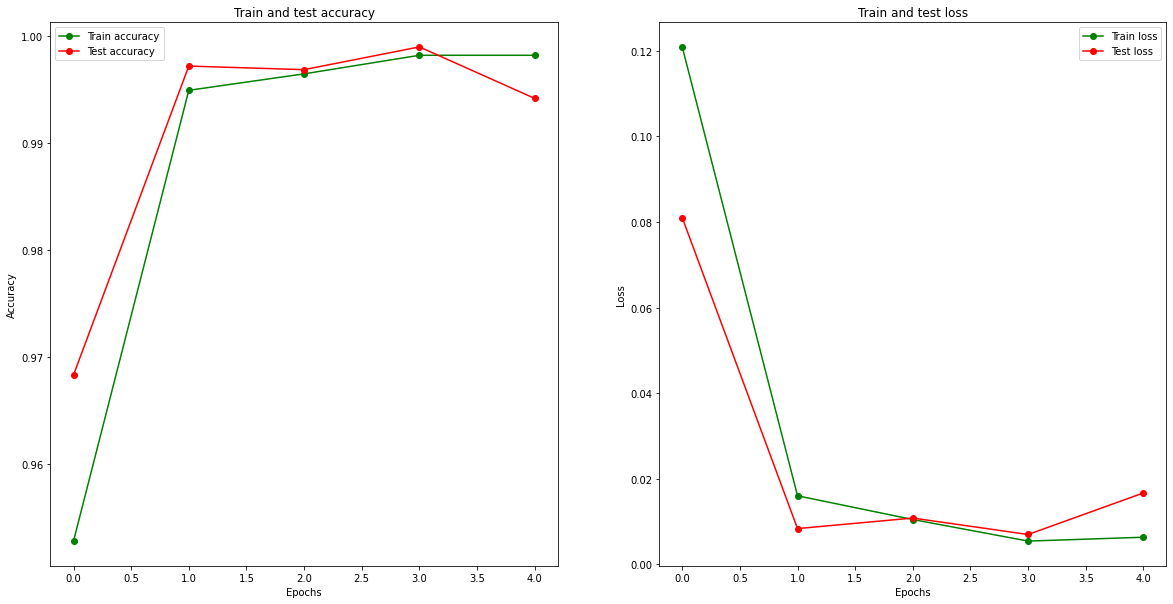

In [50]:
epochs = [i for i in range(5)]

fig, ax = plt.subplots(1, 2)
train_acc = history.history["accuracy"]
train_loss = history.history["loss"]
val_acc = history.history["val_accuracy"]
val_loss = history.history["val_loss"]
fig.set_size_inches(20, 10)

ax[0].plot(epochs, train_acc, "go-", label = "Train accuracy")
ax[0].plot(epochs, val_acc, "ro-", label = "Test accuracy")
ax[0].set_title("Train and test accuracy")
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, "go-", label = "Train loss")
ax[1].plot(epochs, val_loss, "ro-", label = "Test loss")
ax[1].set_title("Train and test loss")
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [51]:
# make prediction
predictions = (model.predict(test_x) > 0.5).astype("int32")

In [54]:
# calc the classes pred
classes_pred = np.argmax(predictions, axis = 1)

print(classification_report(y_test, classes_pred))

              precision    recall  f1-score   support

           0       0.52      1.00      0.68      4633
           1       0.00      0.00      0.00      4305

    accuracy                           0.52      8938
   macro avg       0.26      0.50      0.34      8938
weighted avg       0.27      0.52      0.35      8938



In [159]:
prediction

array([[3.83685715e-03],
       [2.75964732e-04],
       [1.19257955e-08],
       ...,
       [5.89071902e-08],
       [3.83685715e-03],
       [2.01817627e-07]], dtype=float32)

In [160]:
print("Accuracy of the model on Training Data is - " , model.evaluate(train_x,train_y)[1]*100 , "%")
print("*********************************************************************************************")
print("Accuracy of the model on Testing Data is - " , model.evaluate(test_x,test_y)[1]*100 , "%")

1118/1118 [==============================] - 20s 18ms/step - loss: 0.0052 - accuracy: 0.9983
Accuracy of the model on Training Data is -  99.83497262001038 %
*********************************************************************************************
280/280 [==============================] - 6s 20ms/step - loss: 0.0081 - accuracy: 0.9977
Accuracy of the model on Testing Data is -  99.76505041122437 %


In [161]:
cm = confusion_matrix(y_test,predictions)
cm

array([[4617,   16],
       [   5, 4300]])

In [162]:
cm = pd.DataFrame(cm , index = ['Fake','Original'] , columns = ['Fake','Original'])


Text(69.0, 0.5, 'Actual')

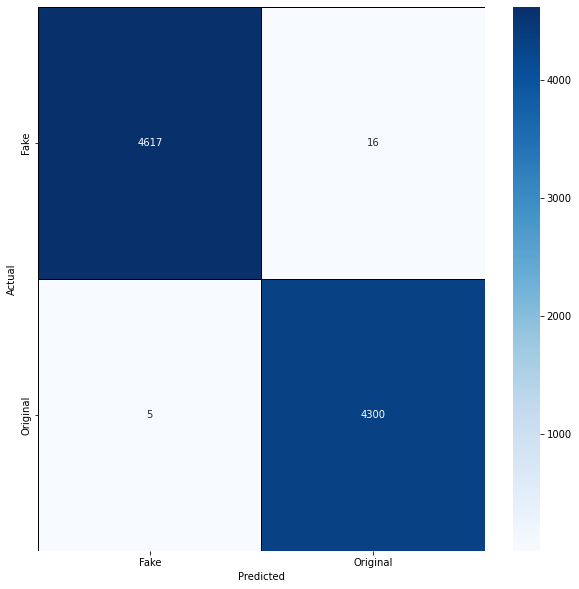

In [163]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Original'] , yticklabels = ['Fake','Original'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [ ]:
# save the model
import pickle
pickle.dump(model, open("model.pkl", "wb"))